In [1]:
import csv
import hashlib
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from encoders.bf_encoder import BFEncoder
from encoders.tmh_encoder import TMHEncoder
from encoders.tsh_encoder import TSHEncoder
from encoders.non_encoder import NonEncoder
from typing import Sequence

In [2]:
def read_tsv(path: str, header: bool = True, as_dict: bool = False, delim: str = "\t") -> Sequence[Sequence[str]]:
    data = {} if as_dict else []
    uid = []
    with open(path, "r") as f:
        reader = csv.reader(f, delimiter=delim)
        if header:
            next(reader)
        for row in reader:
            if as_dict:
                assert len(row) == 3, "Dict mode only supports rows with two values + uid"
                data[row[0]] = row[1]
            else:
                data.append(row[:-1])
                uid.append(row[3])
    return data, uid

In [3]:
%matplotlib inline

In [5]:
GLOBAL_CONFIG = {
    "Data": "../data/fakename_2k.tsv",
    "Verbose": True,
    "Workers": -1
}

ENC_CONFIG = {
    "AliceAlgo": "NonEncoder",
    "AliceSecret": "SuperSecretSalt1337",
    "AliceBFLength": 1024,
    "AliceBits": 40,  # BF: 30, TMH: 1000
    "AliceN": 2,
    "AliceMetric": "dice",
    "EveAlgo": "NonEncoder",
    "EveSecret": "ATotallyDifferentString",
    "EveBFLength": 1024,
    "EveBits": 40,  # BF: 30, TMH: 1000
    "EveN": 2,
    "EveMetric": "dice",
    # For TMH encoding
    "AliceTables": 8,
    "AliceKeyLen": 8,
    "AliceValLen": 128,
    "EveTables": 8,
    "EveKeyLen": 8,
    "EveValLen": 128,
    # For 2SH encoding
    "AliceNHashFunc": 10,
    "AliceNHashCol": 1000,
    "AliceRandMode": "PNG",
    "EveNHashFunc": 10,
    "EveNHashCol": 1000,
    "EveRandMode": "PNG"
}

In [6]:
print("Loading Data")
alice_data, alice_uids = read_tsv(GLOBAL_CONFIG["Data"])
eve_data, eve_uids = read_tsv(GLOBAL_CONFIG["Data"])

if ENC_CONFIG["AliceAlgo"] == "BloomFilter":
    alice_encoder = BFEncoder(ENC_CONFIG["AliceSecret"], ENC_CONFIG["AliceBFLength"],
                              ENC_CONFIG["AliceBits"], ENC_CONFIG["AliceN"])
elif ENC_CONFIG["AliceAlgo"] == "TabMinHash":
    alice_encoder = TMHEncoder(ENC_CONFIG["AliceBits"], ENC_CONFIG["AliceTables"],
                               ENC_CONFIG["AliceKeyLen"], ENC_CONFIG["AliceValLen"], hashlib.md5,
                               ENC_CONFIG["AliceN"],
                               random_seed=ENC_CONFIG["AliceSecret"], verbose=GLOBAL_CONFIG["Verbose"])
elif ENC_CONFIG["AliceAlgo"] == "TwoStepHash":
    alice_encoder = TSHEncoder(ENC_CONFIG["AliceNHashFunc"], ENC_CONFIG["AliceNHashCol"], ENC_CONFIG["AliceN"],
                               ENC_CONFIG["AliceRandMode"], secret=ENC_CONFIG["AliceSecret"],
                               verbose=GLOBAL_CONFIG["Verbose"], workers=GLOBAL_CONFIG["Workers"])
else:
    alice_encoder = NonEncoder(ENC_CONFIG["AliceN"])

if ENC_CONFIG["EveAlgo"] == "BloomFilter":
    eve_encoder = BFEncoder(ENC_CONFIG["EveSecret"], ENC_CONFIG["EveBFLength"],
                            ENC_CONFIG["EveBits"], ENC_CONFIG["EveN"])
elif ENC_CONFIG["EveAlgo"] == "TabMinHash":
    eve_encoder = TMHEncoder(ENC_CONFIG["EveBits"], ENC_CONFIG["EveTables"],
                             ENC_CONFIG["EveKeyLen"], ENC_CONFIG["EveValLen"], hashlib.md5,
                             ENC_CONFIG["EveN"],
                             random_seed=ENC_CONFIG["EveSecret"], verbose=GLOBAL_CONFIG["Verbose"])
elif ENC_CONFIG["EveAlgo"] == "TwoStepHash":
    eve_encoder = TSHEncoder(ENC_CONFIG["EveNHashFunc"], ENC_CONFIG["EveNHashCol"], ENC_CONFIG["EveN"],
                             ENC_CONFIG["EveRandMode"], secret=ENC_CONFIG["EveSecret"],
                             verbose=GLOBAL_CONFIG["Verbose"])
else:
    eve_encoder = NonEncoder(ENC_CONFIG["EveN"])


Loading Data


In [7]:
print("Encoding Alice")
alice_enc = alice_encoder.encode_and_compare(alice_data, alice_uids, metric=ENC_CONFIG["AliceMetric"], sim=False)

print("Encoding Eve")
eve_enc = eve_encoder.encode_and_compare(eve_data, eve_uids, metric=ENC_CONFIG["AliceMetric"], sim=False)

Encoding Alice
Encoding Eve


In [8]:
diffs = alice_enc - eve_enc

In [9]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

Plotting Alice's Similarities


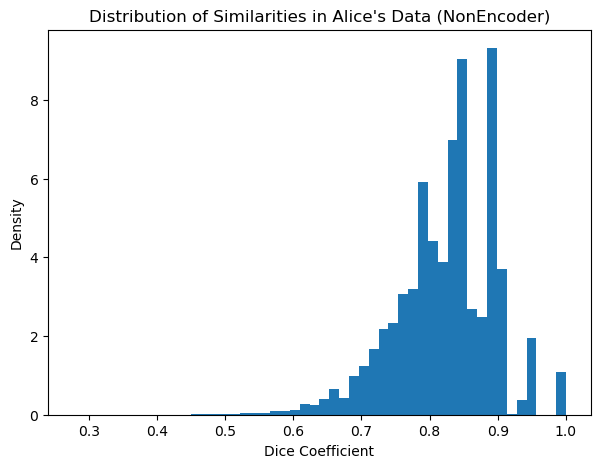

In [10]:
print("Plotting Alice's Similarities")
plt.hist(alice_enc[:,2], bins=50, density=True)
plt.gca().set(title='Distribution of Similarities in Alice\'s Data (' + ENC_CONFIG["AliceAlgo"]+')', ylabel='Density', xlabel='Dice Coefficient')
plt.show()

Plotting Eve's Similarities


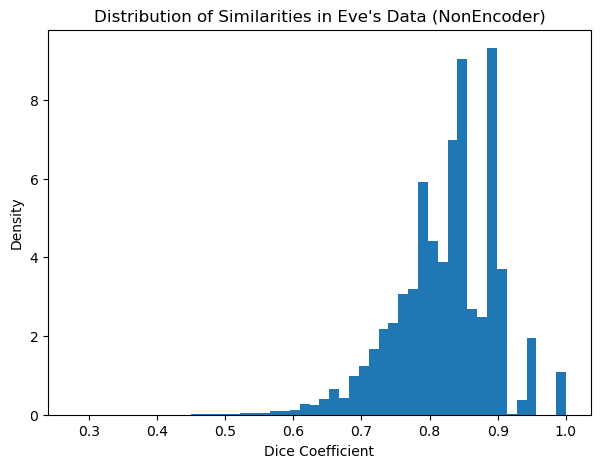

In [11]:
print("Plotting Eve's Similarities")
plt.hist(eve_enc[:,2], bins=50, density=True)
plt.gca().set(title='Distribution of Similarities in Eve\'s Data (' + ENC_CONFIG["AliceAlgo"]+')', ylabel='Density', xlabel='Dice Coefficient')
plt.show()

In [ ]:
# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(diffs[:,2])

In [ ]:
print("Fitted normal distribution with center %f and standard deviation %f" % (mu, std))

In [ ]:
plt.hist(diffs[:,2], bins=50, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = 'Distribution of Differences in Similarities (' + ENC_CONFIG["AliceAlgo"]+')'
plt.title(title)
plt.xlabel("Difference in Dice Coefficients")
plt.ylabel("Density")
plt.show()